In [29]:
# 1️⃣ Import libraries
import pandas as pd
from pymongo import MongoClient
from dotenv import load_dotenv
import os
import matplotlib.pyplot as plt
import seaborn as sns


In [39]:
df.shape

(1, 15)

In [30]:
# 2️⃣ Load MongoDB connection
load_dotenv()
MONGO_URI = os.getenv("MONGO_URI")

client = MongoClient(MONGO_URI)
db = client["aqi_database"]
features_col = db["features"]

In [31]:
# ---------------------------
# 4️⃣ Handle missing values
# ---------------------------
# Check missing values
print(df.isnull().sum())

# Fill missing numerical values with median
numerical_cols = ["pm2_5","pm10","no2","so2","co","o3","temperature","humidity","pressure"]
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].median())


timestamp      0
pm2_5          0
pm10           0
no2            0
so2            0
co             0
o3             0
temperature    0
humidity       0
pressure       0
hour           0
day            0
month          0
aqi            0
aqi_change     0
dtype: int64


In [32]:

# ---------------------------
# 5️⃣ Compute derived features
# ---------------------------
# AQI change rate (difference between consecutive AQI values)
df = df.sort_values("timestamp")
df["aqi_change"] = df["aqi"].diff().fillna(0)


In [33]:

# 6️⃣ Feature importance (correlation with AQI)
# ---------------------------
correlation = df.corr()["aqi"].sort_values(ascending=False)
print("Correlation with AQI:")
print(correlation)

# Select features with high correlation (absolute > 0.3)
important_features = correlation[abs(correlation) > 0.3].index.tolist()
# Remove target 'aqi' from features
important_features = [f for f in important_features if f != "aqi"]

print("Important features selected for training:", important_features)


Correlation with AQI:
timestamp     NaN
pm2_5         NaN
pm10          NaN
no2           NaN
so2           NaN
co            NaN
o3            NaN
temperature   NaN
humidity      NaN
pressure      NaN
hour          NaN
day           NaN
month         NaN
aqi           NaN
aqi_change    NaN
Name: aqi, dtype: float64
Important features selected for training: []


c:\Users\Haroon Traders\aqi_project\.venv\lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\Users\Haroon Traders\aqi_project\.venv\lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


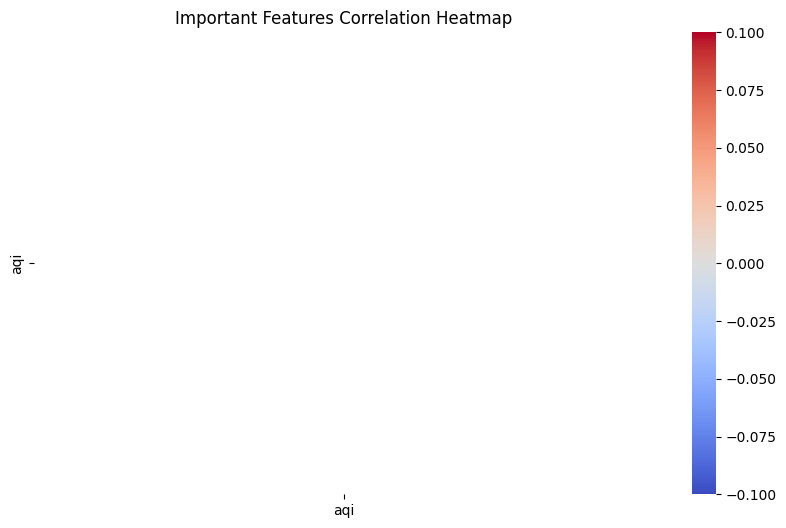

In [34]:
plt.figure(figsize=(10,6))
sns.heatmap(df[important_features + ["aqi"]].corr(), annot=True, cmap="coolwarm")
plt.title("Important Features Correlation Heatmap")
plt.show()

In [28]:
X = df[important_features]
y = df["aqi"]

print("Final feature matrix shape:", X.shape)
print("Target vector shape:", y.shape)

Final feature matrix shape: (1, 0)
Target vector shape: (1,)


Data loaded from MongoDB, shape: (32, 16)
Correlation with AQI:
co             1.000000
pm10           1.000000
aqi            1.000000
pm2_5          1.000000
aqi_change     0.718421
day_of_week   -0.139122
day           -0.139122
hour          -0.227603
timestamp     -0.326941
temperature   -0.999604
o3            -1.000000
so2           -1.000000
humidity      -1.000000
no2                 NaN
pressure            NaN
month               NaN
Name: aqi, dtype: float64
Important features selected for training: ['co', 'pm10', 'pm2_5', 'aqi_change', 'timestamp', 'temperature', 'o3', 'so2', 'humidity']


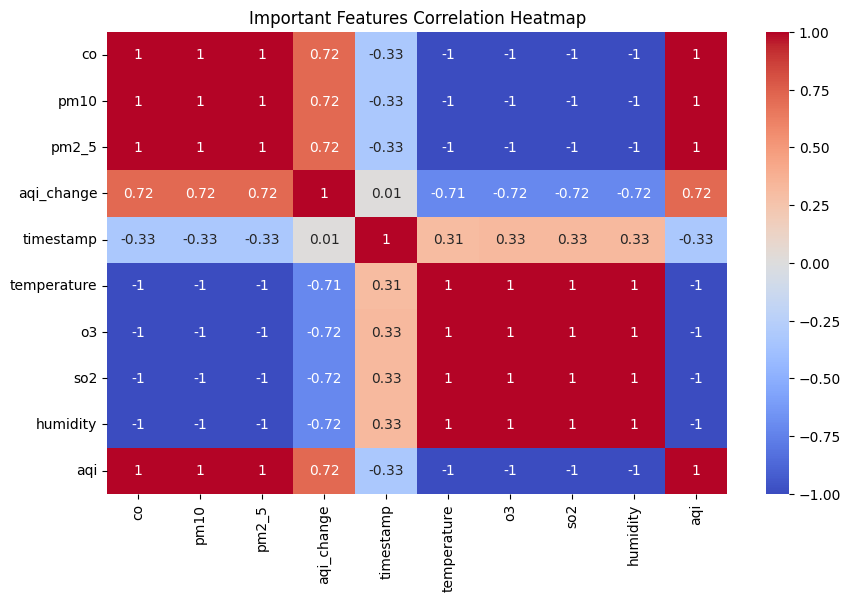

Final feature matrix shape: (32, 9)
Target vector shape: (32,)


In [40]:
# 1️⃣ Import libraries
import pandas as pd
from pymongo import MongoClient
from dotenv import load_dotenv
import os
import matplotlib.pyplot as plt
import seaborn as sns

# 2️⃣ Load environment variables
load_dotenv()
MONGO_URI = os.getenv("MONGO_URI")

# 3️⃣ Connect to MongoDB
client = MongoClient(MONGO_URI)
db = client["aqi_database"]
features_col = db["features"]

# 4️⃣ Load data from MongoDB
df = pd.DataFrame(list(features_col.find()))
print("Data loaded from MongoDB, shape:", df.shape)

# Drop MongoDB default _id column
df = df.drop(columns=["_id"], errors="ignore")

# 5️⃣ Convert timestamp to datetime and sort
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.sort_values("timestamp").reset_index(drop=True)

# 6️⃣ Handle missing numerical values
numerical_cols = ["pm2_5","pm10","no2","so2","co","o3","temperature","humidity","pressure","aqi"]
existing_cols = [c for c in numerical_cols if c in df.columns]
df[existing_cols] = df[existing_cols].fillna(df[existing_cols].median())

# Optional: Fill any remaining missing values with 0
df = df.fillna(0)

# 7️⃣ Compute derived features
# AQI change rate
df["aqi_change"] = df["aqi"].diff().fillna(0)

# Time-based features
df["hour"] = df["timestamp"].dt.hour
df["day"] = df["timestamp"].dt.day
df["month"] = df["timestamp"].dt.month
df["day_of_week"] = df["timestamp"].dt.dayofweek

# 8️⃣ Feature importance (correlation with AQI)
correlation = df.corr()["aqi"].sort_values(ascending=False)
print("Correlation with AQI:")
print(correlation)

# Select features with high correlation (absolute > 0.3)
important_features = correlation[abs(correlation) > 0.3].index.tolist()
# Remove target 'aqi' from features
important_features = [f for f in important_features if f != "aqi"]

if len(important_features) == 0:
    print("Warning: No features meet correlation threshold > 0.3")

print("Important features selected for training:", important_features)

# 9️⃣ Plot correlation heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df[important_features + ["aqi"]].corr(), annot=True, cmap="coolwarm")
plt.title("Important Features Correlation Heatmap")
plt.show()

# 🔟 Prepare feature matrix and target vector
X = df[important_features]
y = df["aqi"]

print("Final feature matrix shape:", X.shape)
print("Target vector shape:", y.shape)
